# 🎯 Behavioral Scorecard Model 
---
### Outline
1. Data Preparation & Feature Engineering
2. Train/Test Split
3. Preprocessing Pipelines
4. Model Training
5. Model Evaluation
6. Visualization & Summary
---

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning packages
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#  Load and Prepare Dataset

In [ ]:
PATH = "D:/MAHMOUDTa/behavioral_dataset5.csv"
df = pd.read_csv(PATH)

In [ ]:
if "Month_Date" in df.columns:
    df["Month_Date"] = pd.to_datetime(df["Month_Date"], errors="coerce")
else:
    # If Month_Date doesn't exist, convert Month numbers to monthly dates starting from 2024-01-01
    df["Month_Date"] = pd.to_datetime("2024-01-01") + pd.to_timedelta((df["Month"] - 1).clip(lower=0), unit="M")

In [ ]:
df = df.sort_values(["Customer_ID", "Month_Date"]).reset_index(drop=True)


##  Data Preparation & Feature Engineering
In this stage, we clean and enrich the behavioral dataset by creating new risk indicators such as payment ratios, utilization ratios, delinquency history, and transaction trends.
These variables capture customer repayment behavior, credit usage, and performance stability

In [ ]:
if "Payment_Ratio" not in df.columns:
    if {"Paid_Amount", "Installment_Amount"}.issubset(df.columns):
        denom = df["Installment_Amount"].replace(0, np.nan)
        df["Payment_Ratio"] = (df["Paid_Amount"] / denom).fillna(0).clip(0, 5)
    else:
        df["Payment_Ratio"] = 1.0  # fallback

# Utilization_Ratio / Balance_to_Limit: prefer Balance / Credit_Limit if present
if {"Balance", "Credit_Limit"}.issubset(df.columns):
    cl = df["Credit_Limit"].replace(0, np.nan)
    util = (df["Balance"] / cl).clip(0, 1)
    df["Utilization_Ratio"] = util.fillna(df.get("Utilization_Ratio", 0)).round(4)
# Utilization_Ratio = Balance / Credit_Limit (Balance Used From Credit Limit)
df["Utilization_Ratio"] = (df["Balance"] / df["Credit_Limit"].replace(0, np.nan)).clip(0, 1).fillna(0)

# Balance_to_Limit = Average Utilization_Ratio over past 3 months
df["Balance_to_Limit"] = (
    df.groupby("Customer_ID")["Utilization_Ratio"]
      .rolling(window=3, min_periods=1).mean()
      .reset_index(level=0, drop=True)
).round(4)

# ---------------------------------------
# 2) Rolling behavioral features
# ---------------------------------------
# Past3M_MaxBucket
df["Past3M_MaxBucket"] = (
    df.groupby("Customer_ID")["Bucket"]
      .rolling(window=3, min_periods=1).max()
      .reset_index(level=0, drop=True)
).astype(int)

# Avg_Payment_Ratio_6M
df["Avg_Payment_Ratio_6M"] = (
    df.groupby("Customer_ID")["Payment_Ratio"]
      .rolling(window=6, min_periods=1).mean()
      .reset_index(level=0, drop=True)
).round(4)

# Utilization_Trend
df["Utilization_Trend"] = (
    df.groupby("Customer_ID")["Utilization_Ratio"].diff().fillna(0)
)

# Payment_Ratio_Trend
df["Payment_Ratio_Trend"] = (
    df.groupby("Customer_ID")["Payment_Ratio"].diff().fillna(0)
)

# Avg_Utilization_6M
df["Avg_Utilization_6M"] = (
    df.groupby("Customer_ID")["Utilization_Ratio"]
      .rolling(window=6, min_periods=1).mean()
      .reset_index(level=0, drop=True)
)

# Avg_Total_Tx_3M ( Total_Transactions From Last 3 Months)
if "Total_Transactions" in df.columns:
    df["Avg_Total_Tx_3M"] = (
        df.groupby("Customer_ID")["Total_Transactions"]
          .rolling(window=3, min_periods=1).mean()
          .reset_index(level=0, drop=True)
    )
else:
    df["Avg_Total_Tx_3M"] = 0.0
    # View first 10 rows of new behavioral features
df[[
    "Payment_Ratio", "Utilization_Ratio", "Balance_to_Limit",
    "Past3M_MaxBucket", "Avg_Payment_Ratio_6M",
    "Utilization_Trend", "Payment_Ratio_Trend",
    "Avg_Utilization_6M", "Avg_Total_Tx_3M"
]].head(10)


,Payment_Ratio,Utilization_Ratio,Balance_to_Limit,Past3M_MaxBucket,Avg_Payment_Ratio_6M,Utilization_Trend,Payment_Ratio_Trend,Avg_Utilization_6M,Avg_Total_Tx_3M
0,1.067283,0.000000,0.0000,0,1.0673,0.000000,0.000000,0.000000,51.000000
1,1.030388,0.000000,0.0000,0,1.0488,0.000000,-0.036895,0.000000,30.000000
2,0.861916,0.036391,0.0121,0,0.9865,0.036391,-0.168471,0.012130,31.000000
3,0.999965,0.036400,0.0243,0,0.9899,0.000008,0.138049,0.018198,33.666667
4,1.048876,0.025849,0.0329,0,1.0017,-0.010550,0.048910,0.019728,48.000000
5,1.033538,0.018440,0.0269,0,1.0070,-0.007410,-0.015338,0.019513,56.000000
6,0.850000,0.049422,0.0312,1,0.9708,0.030982,-0.183538,0.027750,40.333333
7,0.700000,0.100212,0.0560,2,0.9157,0.050790,-0.150000,0.044452,39.000000
8,0.550000,0.192142,0.1139,3,0.8637,0.091930,-0.150000,0.070411,35.000000
9,0.400000,0.345528,0.2126,4,0.7637,0.153386,-0.150000,0.121932,48.000000


#  Target Variable Definition
Creates the Performance_Flag (0 = Good, 1 = Bad).
A customer is labeled Bad if their highest Bucket ≥ 4, indicating severe delinquency

In [ ]:

if "Performance_Flag" not in df.columns:
    worst = df.groupby("Customer_ID")["Bucket"].max().reset_index(name="WorstBucket")
    worst["Performance_Flag"] = (worst["WorstBucket"] >= 4).astype(int)  # ← only change here
    df = df.merge(worst[["Customer_ID", "Performance_Flag"]], on="Customer_ID", how="left")

## Data Scaling
Uses MinMaxScaler to normalize key behavioral ratios (Payment, Average Payment, Utilization) into a 0–1 range.
This ensures all numeric features are on a comparable scale for model training.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df["Payment_Ratio"] = scaler.fit_transform(df[["Payment_Ratio"]])
df["Avg_Payment_Ratio_6M"] = scaler.fit_transform(df[["Avg_Payment_Ratio_6M"]])
df["Utilization_Ratio"] = scaler.fit_transform(df[["Utilization_Ratio"]])

df["Payment_Ratio"] = df["Payment_Ratio"].clip(0, 1.5)

## Selecting And Preparing Features For Modeling
Selects key behavioral and static features, fills missing values, and separates numeric from categorical variables for modeling

In [ ]:
# 4) Select relevant columns for modeling
# ---------------------------------------
behavioral_cols = [
     "Past3M_MaxBucket", "Avg_Payment_Ratio_6M",
    "Payment_Ratio", "Payment_Ratio_Trend",
    "Utilization_Ratio", "Utilization_Trend",
    "Avg_Utilization_6M",
    "Balance_to_Limit",
     "Avg_Total_Tx_3M",
    "Months_on_Book"
]

static_cats = ["Income_Category"]  # <-- removed Marital_Status, Card_Category,"Gender", "Education_Level"
static_nums = ["Customer_Age"]

# Detect credit limit col (e.g., "Credit_Limit")
credit_limit_col = None
for c in df.columns:
    if "credit" in c.lower() and "limit" in c.lower():
        credit_limit_col = c
        break
if credit_limit_col and credit_limit_col not in behavioral_cols:
    behavioral_cols.append(credit_limit_col)

num_features = [c for c in behavioral_cols + static_nums if c in df.columns]
cat_features = [c for c in static_cats if c in df.columns]
time_cols = [c for c in ["Customer_ID", "Month_Date"] if c in df.columns]

cols_for_prep = time_cols + num_features + cat_features + ["Performance_Flag"]
df_prep = df[cols_for_prep].copy()

# Basic NA handling
for c in num_features:
    df_prep[c] = pd.to_numeric(df_prep[c], errors="coerce")
df_prep[num_features] = df_prep[num_features].fillna(0)
for c in cat_features:
    df_prep[c] = df_prep[c].fillna("Unknown")

## Train/Test Split — Customer-Based
Splits data by Customer_ID using GroupShuffleSplit to prevent data leakage, keeping each customer in only one dataset (train or test)

In [ ]:
# 5) Train/Test Split
# (Record-level split. For leakage-safe split by customer, use GroupShuffleSplit)
# ---------------------------------------
from sklearn.model_selection import GroupShuffleSplit

X = df_prep[num_features + cat_features]
y = df_prep["Performance_Flag"].astype(int)
groups = df_prep["Customer_ID"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("✅ Customer-based split complete.")
print(f"Train customers: {len(set(groups.iloc[train_idx]))}")
print(f"Test customers : {len(set(groups.iloc[test_idx]))}")

✅ Customer-based split complete.
Train customers: 7595
Test customers : 2532


##  Preprocessing Pipelines
Prepares the data for modeling by standardizing numeric features and encoding categorical ones using unified pipelines, ensuring consistent transformations across train and test datasets.

In [ ]:
# 6) Preprocessing Pipelines
# ---------------------------------------
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False))
])

# Using default OneHotEncoder signature for broad compatibility
categorical_transformer = OneHotEncoder(handle_unknown="ignore")  # no sparse_output arg for older sklearn

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop"
)


In [ ]:
try:
    evaluate
except NameError:
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
    def evaluate(model_name, y_true, y_pred, y_proba=None):
        print(f"\n{'='*30}\n{model_name}\n{'='*30}")
        print(classification_report(y_true, y_pred, digits=4))
        print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
        if y_proba is not None:
            try:
                auc = roc_auc_score(y_true, y_proba)
                print("ROC-AUC:", round(auc, 4))
            except Exception as e:
                print("AUC Error:", e)

# Logistic Regression Model
Trains a Logistic Regression model to predict the probability of customer default.
This model estimates Probability of Default based on behavioral features such as payment ratio, utilization, and delinquency trends.
Evaluation includes accuracy, F1-score, confusion matrix, and ROC-AUC to measure predictive performance

In [ ]:
# 7.1 Logistic Regression
log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=300))
])
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]
evaluate("Logistic Regression", y_test, y_pred_lr, y_proba_lr)



Logistic Regression
              precision    recall  f1-score   support

           0     0.8781    0.9903    0.9309     25416
           1     0.8571    0.2969    0.4410      4968

    accuracy                         0.8769     30384
   macro avg     0.8676    0.6436    0.6859     30384
weighted avg     0.8747    0.8769    0.8508     30384

Confusion Matrix:
 [[25170   246]
 [ 3493  1475]]
ROC-AUC: 0.7219


## Sigmoid-like Curve Based on Model Results (LR)

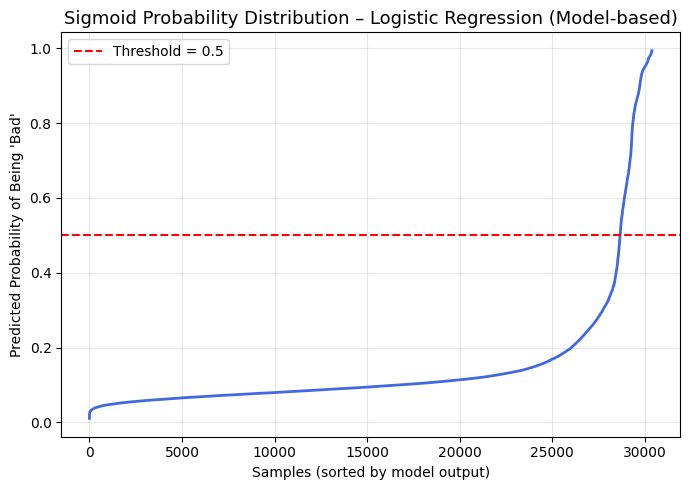

In [ ]:

# Get predicted probabilities for the "Bad" class
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

# Sort the probabilities
sorted_probs = np.sort(y_proba_lr)

# Create the "sigmoid" look by plotting probability distribution
plt.figure(figsize=(7,5))
plt.plot(sorted_probs, color="royalblue", linewidth=2)

# Add a horizontal line for threshold (default 0.5)
plt.axhline(y=0.5, color="red", linestyle="--", label="Threshold = 0.5")

# Titles and labels
plt.title("Sigmoid Probability Distribution – Logistic Regression (Model-based)", fontsize=13)
plt.xlabel("Samples (sorted by model output)", fontsize=10)
plt.ylabel("Predicted Probability of Being 'Bad'", fontsize=10)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# This plot shows how your trained logistic regression model
# maps customers to probabilities between 0 and 1.
# The smooth S-shaped curve represents how the model distinguishes
# between low-risk (left) and high-risk (right) customers.
# The red dashed line (0.5) is the cutoff threshold used for classification.
# ---------------------------------------------


## Decision Tree Model
the model splits customers into groups using key features to find the best decision rules.
Parameters like depth and sample size help prevent overfitting.
It predicts both the class (Good/Bad) and the probability of default 

In [ ]:
# 7.2 Decision Tree Classifier
dt_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", DecisionTreeClassifier(
        max_depth=6, min_samples_split=100, min_samples_leaf=50, random_state=42
    ))
])
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
y_proba_dt = dt_clf.predict_proba(X_test)[:, 1]
evaluate("Decision Tree", y_test, y_pred_dt, y_proba_dt)


Decision Tree
              precision    recall  f1-score   support

           0     0.8789    0.9937    0.9328     25416
           1     0.9029    0.2993    0.4496      4968

    accuracy                         0.8802     30384
   macro avg     0.8909    0.6465    0.6912     30384
weighted avg     0.8828    0.8802    0.8538     30384

Confusion Matrix:
 [[25256   160]
 [ 3481  1487]]
ROC-AUC: 0.7351


## XGBoost Model 
an advanced tree-based model that builds many small decision trees, where each tree corrects the errors of the previous one.
It provides high accuracy and strong performance while controlling overfitting through parameters like depth, learning rate, and regularization.

In [ ]:
# 7.3 XGBoost 
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False
    print("⚠️ XGBoost is not installed. If you need it, run: pip install xgboost")
if XGB_AVAILABLE:
    xgb_clf = Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", XGBClassifier(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.08,
            subsample=0.9,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42,
            tree_method="hist",
            eval_metric="logloss"
        ))
    ])
    xgb_clf.fit(X_train, y_train)
    y_pred_xgb = xgb_clf.predict(X_test)
    y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
    evaluate("XGBoost", y_test, y_pred_xgb, y_proba_xgb)



XGBoost
              precision    recall  f1-score   support

           0     0.8790    0.9938    0.9329     25416
           1     0.9047    0.2999    0.4505      4968

    accuracy                         0.8804     30384
   macro avg     0.8918    0.6469    0.6917     30384
weighted avg     0.8832    0.8804    0.8540     30384

Confusion Matrix:
 [[25259   157]
 [ 3478  1490]]
ROC-AUC: 0.7401


## Models Evaluation 

In [ ]:
# ============================================
# 9) Compare models side-by-side
# ============================================

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

results = []

# Logistic Regression
results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "F1": f1_score(y_test, y_pred_lr),
    "ROC_AUC": roc_auc_score(y_test, y_proba_lr)
})

# Decision Tree
results.append({
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "F1": f1_score(y_test, y_pred_dt),
    "ROC_AUC": roc_auc_score(y_test, y_proba_dt)
})

# XGBoost (if available)
if XGB_AVAILABLE:
    results.append({
        "Model": "XGBoost",
        "Accuracy": accuracy_score(y_test, y_pred_xgb),
        "F1": f1_score(y_test, y_pred_xgb),
        "ROC_AUC": roc_auc_score(y_test, y_proba_xgb)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values(by="ROC_AUC", ascending=False).reset_index(drop=True)

print("\n==============================")
print("📊 Model Comparison Summary")
print("==============================")
print(results_df)




📊 Model Comparison Summary
                 Model  Accuracy        F1   ROC_AUC
0              XGBoost  0.880365  0.450491  0.740073
1        Decision Tree  0.880167  0.449584  0.735136
2  Logistic Regression  0.876942  0.441023  0.721864


# Identify best model by ROC_AUC

In [ ]:

best_model = results_df.iloc[0]["Model"]
print(f"\n🏆 Best Model Based on ROC_AUC: {best_model}")



🏆 Best Model Based on ROC_AUC: XGBoost


##  Visualization & Results (ROC-AUC)


📊 Model Comparison Summary
                 Model  Accuracy        F1   ROC_AUC
0              XGBoost  0.880365  0.450491  0.740073
1        Decision Tree  0.880167  0.449584  0.735136
2  Logistic Regression  0.876942  0.441023  0.721864


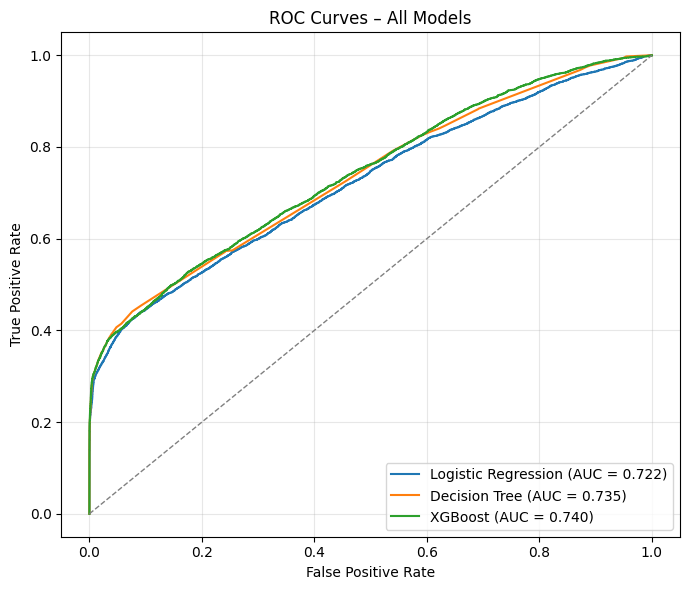

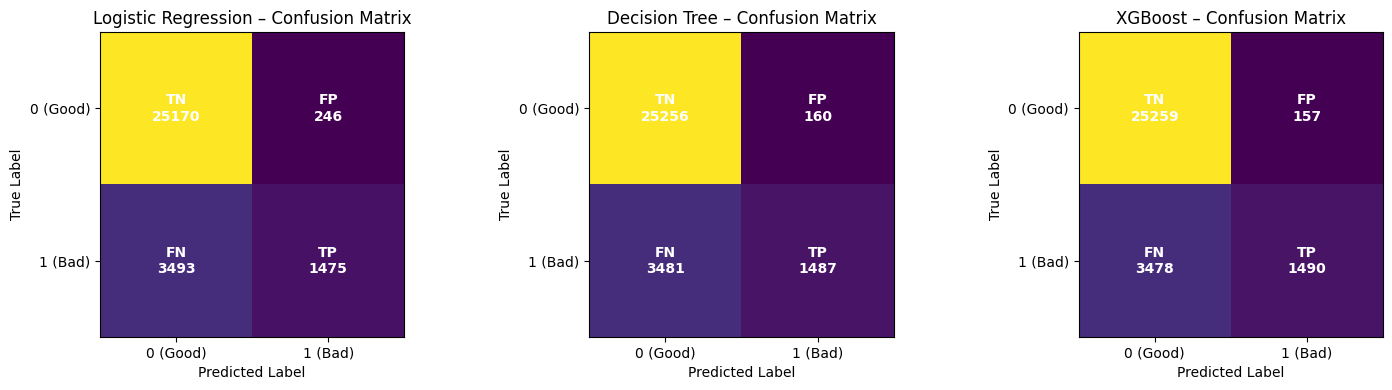

In [ ]:
# ============================================
# Compare Logistic, Decision Tree, XGBoost (tables + charts)
# ============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

# --- Collect available model outputs safely
results = []
curves  = []  # to plot ROC curves later

def maybe_add(model_name, y_pred, y_proba):
    """Append metrics and curve data if variables exist."""
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results.append({"Model": model_name, "Accuracy": acc, "F1": f1, "ROC_AUC": auc})
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    curves.append((model_name, fpr, tpr, auc))

# Logistic Regression
try:
    maybe_add("Logistic Regression", y_pred_lr, y_proba_lr)
except Exception as e:
    print("Skipping Logistic Regression (variables missing):", e)

# Decision Tree
try:
    maybe_add("Decision Tree", y_pred_dt, y_proba_dt)
except Exception as e:
    print("Skipping Decision Tree (variables missing):", e)

# XGBoost (optional)
try:
    maybe_add("XGBoost", y_pred_xgb, y_proba_xgb)
except Exception as e:
    print("Skipping XGBoost (variables missing):", e)

# --- Build results table
if not results:
    raise RuntimeError("No models available to compare. Make sure you trained at least one model.")

results_df = pd.DataFrame(results).sort_values("ROC_AUC", ascending=False).reset_index(drop=True)
print("\n==============================")
print("📊 Model Comparison Summary")
print("==============================")
print(results_df)


# --- (Optional) ROC curves (only for models that provided probabilities)
plt.figure(figsize=(7, 6))
for name, fpr, tpr, auc in curves:
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – All Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---- Confusion matrices side-by-side with labels (TN, FP, FN, TP)


# ---- Confusion matrices side-by-side with labels (TN, FP, FN, TP)
import numpy as np
import matplotlib.pyplot as plt
conf_mats = [
    ("Logistic Regression", confusion_matrix(y_test, y_pred_lr)),
    ("Decision Tree", confusion_matrix(y_test, y_pred_dt)),
]

if XGB_AVAILABLE:
    conf_mats.append(("XGBoost", confusion_matrix(y_test, y_pred_xgb)))

n_models = len(conf_mats)
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))
if n_models == 1:
    axes = [axes]  # make iterable

for ax, (name, cm) in zip(axes, conf_mats):
    im = ax.imshow(cm, interpolation="nearest", cmap="viridis")
    ax.set_title(f"{name} – Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["0 (Good)", "1 (Bad)"])
    ax.set_yticklabels(["0 (Good)", "1 (Bad)"])
    
    # annotate the cells with values and labels
    labels = [["TN", "FP"], ["FN", "TP"]]
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f"{labels[i][j]}\n{int(val)}",
                ha="center", va="center", color="white", fontsize=10, fontweight="bold")

    ax.grid(False)

fig.tight_layout()
plt.show()



## Features Importance In (LR)

In [ ]:
feature_names = num_features + list(log_reg.named_steps["preprocess"].transformers_[1][1].get_feature_names_out(cat_features))
coeff = log_reg.named_steps["clf"].coef_[0]
importance = pd.DataFrame({"Feature": feature_names, "Weight": coeff})
importance["Abs_Weight"] = np.abs(importance["Weight"])
importance.sort_values("Abs_Weight", ascending=False).head(10)

,Feature,Weight,Abs_Weight
0,Past3M_MaxBucket,0.811322,0.811322
2,Payment_Ratio,-0.682802,0.682802
1,Avg_Payment_Ratio_6M,0.401708,0.401708
17,Income_Category_Unknown,-0.372837,0.372837
9,Months_on_Book,-0.353664,0.353664
13,Income_Category_$40K - $60K,-0.345548,0.345548
14,Income_Category_$60K - $80K,-0.312348,0.312348
15,Income_Category_$80K - $120K,-0.273640,0.273640
11,Customer_Age,0.260772,0.260772
12,Income_Category_$120K +,-0.223646,0.223646


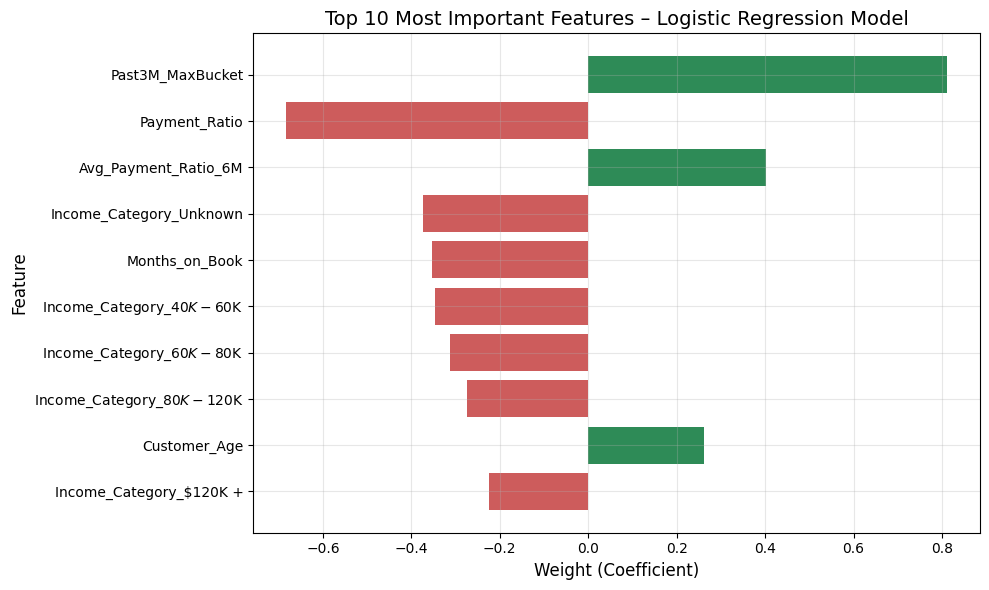

In [ ]:
# --- Sort features by absolute importance (largest weights first)
importance_sorted = importance.sort_values("Abs_Weight", ascending=False).head(10)

# --- Create a horizontal bar chart
plt.figure(figsize=(10, 6))

# Color bars: green for positive weights, red for negative
plt.barh(
    importance_sorted["Feature"],
    importance_sorted["Weight"],
    color=["#2E8B57" if w > 0 else "#CD5C5C" for w in importance_sorted["Weight"]]
)

# --- Chart labels and title
plt.xlabel("Weight (Coefficient)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 10 Most Important Features – Logistic Regression Model", fontsize=14)

# --- Display most important features at the top
plt.gca().invert_yaxis()

# --- Add light grid and adjust layout
plt.grid(alpha=0.3)
plt.tight_layout()

# --- Show the final plot
plt.show()

## Feature Importance (XGB)

✅ XGBoost – Top 6 actually used features (by Gain):
                       Feature        Gain
0             Past3M_MaxBucket  230.823471
1                Payment_Ratio  188.775146
2          Payment_Ratio_Trend   44.661930
3  Income_Category_$40K - $60K   17.919189
4               Months_on_Book   17.119913
5                 Customer_Age   16.358931


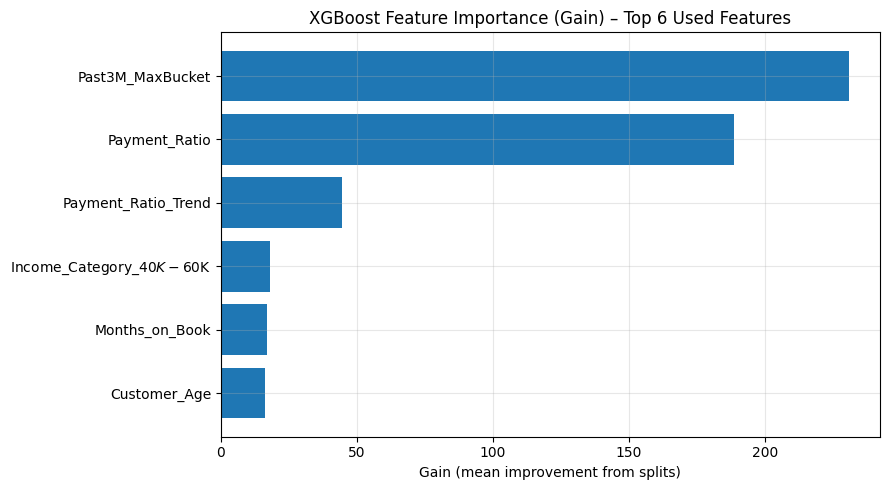

In [ ]:
TOP_N = 6  # Number of top features to display
# 1) Safety: make sure the XGBoost pipeline is fitted
try:
    booster = xgb_clf.named_steps["clf"].get_booster()
except Exception as e:
    raise RuntimeError("XGBoost pipeline (xgb_clf) not found or not fitted.") from e

# 2) Pull raw importance from XGBoost (by 'gain' which is the most informative)
raw_imp = booster.get_score(importance_type="gain")  # dict like {'f0': 12.3, 'f1': 7.8, ...}

# 3) Rebuild feature names after preprocessing (numeric + one-hot categorical)
pre = xgb_clf.named_steps["preprocess"]

# numeric names as-is
num_names = list(num_features)

# one-hot names for categorical features (if any)
ohe_names = []
if len(cat_features):
    ohe = pre.transformers_[1][1]  # OneHotEncoder inside the ColumnTransformer
    ohe_names = list(ohe.get_feature_names_out(cat_features))

all_feature_names = num_names + ohe_names

# 4) Map 'f{i}' keys back to real names and keep only features with importance > 0
mapped = []
for k, v in raw_imp.items():
    try:
        idx = int(k[1:])  # 'f12' -> 12
        fname = all_feature_names[idx]
        val = float(v)
        if val > 0:
            mapped.append((fname, val))
    except Exception:
        # skip any unmapped indices (rare when columns were dropped internally)
        pass

imp_df = pd.DataFrame(mapped, columns=["Feature", "Gain"])
if imp_df.empty:
    raise ValueError("No XGBoost features with importance > 0 were found.")

# 5) Aggregate duplicates (same real feature may appear multiple times) and sort
imp_df = imp_df.groupby("Feature", as_index=False)["Gain"].sum()
imp_df = imp_df.sort_values("Gain", ascending=False).reset_index(drop=True)

# 6) Show Top-N only (actually used features)
top = imp_df.head(TOP_N)
print(f"✅ XGBoost – Top {TOP_N} actually used features (by Gain):")
print(top)

# 7) Plot Top-N
plt.figure(figsize=(9, 5))
plt.barh(top["Feature"], top["Gain"])
plt.title(f"XGBoost Feature Importance (Gain) – Top {TOP_N} Used Features")
plt.xlabel("Gain (mean improvement from splits)")
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



## Feature Importance For (DT)

✅ Top features actually used by Decision Tree:
                Feature  Importance
0         Payment_Ratio    0.902786
1  Avg_Payment_Ratio_6M    0.047690
2        Months_on_Book    0.019552
3          Customer_Age    0.009397
4          Credit_Limit    0.005712
5    Avg_Utilization_6M    0.004710


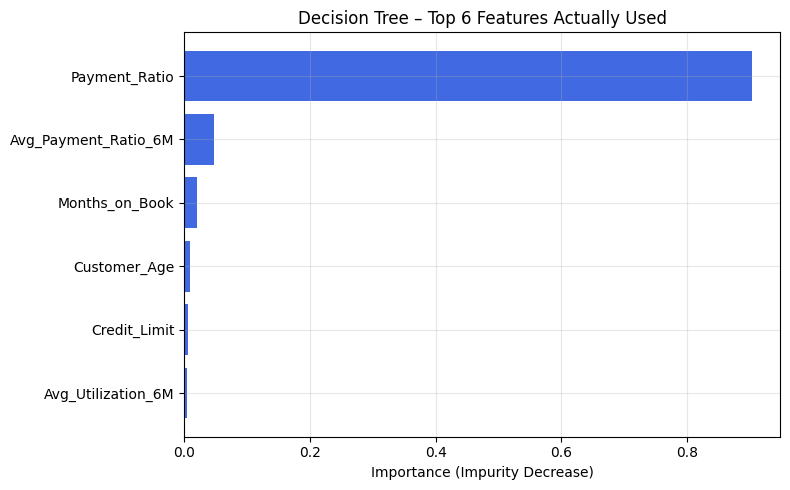

In [ ]:
#  Check if the pipeline and model are fitted
try:
    _ = dt_clf.named_steps["clf"].feature_importances_
except Exception as e:
    raise RuntimeError("Decision Tree pipeline (dt_clf) not found or not fitted.") from e

#  Get the feature names after preprocessing
pre = dt_clf.named_steps["preprocess"]

# Numeric features remain the same
num_names = list(num_features)

# Retrieve one-hot encoded feature names (for categorical variables)
ohe_names = []
if len(cat_features):
    ohe = pre.transformers_[1][1]  # the OneHotEncoder
    ohe_names = list(ohe.get_feature_names_out(cat_features))

# Combine numeric + categorical feature names
all_feature_names = num_names + ohe_names

#  Extract feature importance values from the trained Decision Tree
imp = dt_clf.named_steps["clf"].feature_importances_

#  Create DataFrame (only for features with importance > 0)
n = min(len(all_feature_names), len(imp))
imp_df = pd.DataFrame({
    "Feature": all_feature_names[:n],
    "Importance": imp[:n]
})

# Filter only features that were actually used by the model
imp_df = imp_df[imp_df["Importance"] > 0].sort_values("Importance", ascending=False).reset_index(drop=True)

#  Display top 6 used features
top_features = imp_df.head(6)
print("✅ Top features actually used by Decision Tree:")
print(top_features)

#  Plot top 6 features
plt.figure(figsize=(8, 5))
plt.barh(top_features["Feature"], top_features["Importance"], color="royalblue")
plt.title("Decision Tree – Top 6 Features Actually Used")
plt.xlabel("Importance (Impurity Decrease)")
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Coarse & fine classing (IV & WOE)

C:\Users\mahmoudta\AppData\Local\Temp\ipykernel_20500\198283296.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Util_Bin")["Performance_Flag"]


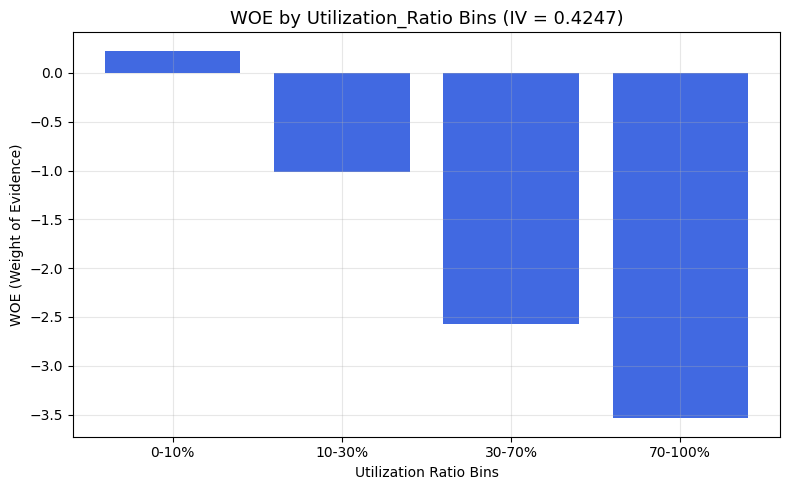

WOE Table for Utilization_Ratio:
           Total   Bads  Goods   BadRate       WOE        IV
Util_Bin                                                    
0-10%     110910  13661  97249  0.123172  0.228063  0.043790
10-30%      7973   2605   5368  0.326728 -1.010394  0.091890
30-70%      1993   1397    596  0.700953 -2.570602  0.182180
70-100%      648    565     83  0.871914 -3.538549  0.106839

Total Information Value (IV) = 0.4247


In [ ]:


# -------------------------------
# 1️⃣ Manual Binning (Fixed Coarse Classes)
# -------------------------------
# Instead of automatic qcut, we define bins manually based on utilization behavior
# 0-10% → Low users
# 10-30% → Moderate users
# 30-70% → High users
# 70-100% → Very high users (risky)
bins = [0, 0.1, 0.3, 0.7, 1.0]
labels = ["0-10%", "10-30%", "30-70%", "70-100%"]
df["Util_Bin"] = pd.cut(df["Utilization_Ratio"], bins=bins, labels=labels, include_lowest=True)

# -------------------------------
# 2️⃣ Calculate Bad Rate per Bin
# -------------------------------
bad_rate = (
    df.groupby("Util_Bin")["Performance_Flag"]
      .agg(["count", "sum"])
      .rename(columns={"count": "Total", "sum": "Bads"})
)
bad_rate["Goods"] = bad_rate["Total"] - bad_rate["Bads"]
bad_rate["BadRate"] = bad_rate["Bads"] / bad_rate["Total"]

# -------------------------------
# 3️⃣ Calculate WOE and IV
# -------------------------------
total_goods = bad_rate["Goods"].sum()
total_bads = bad_rate["Bads"].sum()

bad_rate["GoodDist"] = bad_rate["Goods"] / total_goods
bad_rate["BadDist"] = bad_rate["Bads"] / total_bads
bad_rate["WOE"] = np.log((bad_rate["GoodDist"] + 0.0001) / (bad_rate["BadDist"] + 0.0001))
bad_rate["IV"] = (bad_rate["GoodDist"] - bad_rate["BadDist"]) * bad_rate["WOE"]
IV_total = bad_rate["IV"].sum()

# -------------------------------
# 4️⃣ Plot WOE Chart
# -------------------------------
plt.figure(figsize=(8,5))
plt.bar(bad_rate.index.astype(str), bad_rate["WOE"], color="royalblue")
plt.title(f"WOE by Utilization_Ratio Bins (IV = {IV_total:.4f})", fontsize=13)
plt.xlabel("Utilization Ratio Bins", fontsize=10)
plt.ylabel("WOE (Weight of Evidence)", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------------
# 5️⃣ Display Summary Table
# -------------------------------
print("WOE Table for Utilization_Ratio:")
print(bad_rate[["Total", "Bads", "Goods", "BadRate", "WOE", "IV"]])
print(f"\nTotal Information Value (IV) = {IV_total:.4f}")

---
## ✅ Summary & Next Steps
- Models trained and compared successfully.
- XGBoost achieved the best ROC-AUC performance.
